### PROGETTO FINALE IDS 


Utilizzeremo un dataset della stagione di calcio della Serie A 2023/2024, per provare a predire le ultime 5 giornate che vanno dalla 33° giornata alla 38°giornata.
In un campionato con 20 squadre e un totale di 38 giornate, ogni squadra gioca 38 partite (una per giornata).

Vogliamo considerare le ultime 5 giornate del campionato, quindi 50 partite in totale (10 partite per giornata × 5 giornate).

Per ciascuna partita, proveremo a prevedere il risultato usando uno dei seguenti segni:

1: vittoria della squadra di casa

X: pareggio

2: vittoria della squadra in trasferta

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn

### PASSO 1 INTEGRIAMO IL FILE DELLE PARTITE E LO PULIAMO

Importiamo la tabella Serie A_matches_23_24.csv che contiene i risultati di tutte le partite del campionato e guardiamo cosa contiene con .head

In [52]:
matches = pd.read_csv('dataset/Serie A_matches_23_24.csv')
matches.head()


,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1,1,Empoli,Hellas Verona,2023-08-19T16:30:00Z,True,True,False,False,0_1,Full-Time,NaN,NaN,NaN,NaN
1,1,1,Frosinone,Napoli,2023-08-19T16:30:00Z,True,True,False,False,1_3,Full-Time,NaN,NaN,NaN,NaN
2,1,1,Genoa,Fiorentina,2023-08-19T18:45:00Z,True,True,False,False,1_4,Full-Time,NaN,NaN,NaN,NaN
3,1,1,Inter,Monza,2023-08-19T18:45:00Z,True,True,False,False,2_0,Full-Time,NaN,NaN,NaN,NaN
4,1,1,Roma,Salernitana,2023-08-20T16:30:00Z,True,True,False,False,2_2,Full-Time,NaN,NaN,NaN,NaN


Come si puo notare dalla tabella, Round e roundname indicano la stessa cosa.
Ci sono delle colonne vuote e le eliminiamo.

In [53]:
drop_columns = ['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14','Round Name']
matches.drop(drop_columns, axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status
0,1,Empoli,Hellas Verona,2023-08-19T16:30:00Z,True,True,False,False,0_1,Full-Time
1,1,Frosinone,Napoli,2023-08-19T16:30:00Z,True,True,False,False,1_3,Full-Time
2,1,Genoa,Fiorentina,2023-08-19T18:45:00Z,True,True,False,False,1_4,Full-Time
3,1,Inter,Monza,2023-08-19T18:45:00Z,True,True,False,False,2_0,Full-Time
4,1,Roma,Salernitana,2023-08-20T16:30:00Z,True,True,False,False,2_2,Full-Time


In [54]:
#controlliamo se ci sono valori nulli
matches.isnull().sum()

Round           0
Home Team       0
Away Team       0
UTC Time        0
Finished        0
Started         0
Cancelled       0
Awarded         0
Score           0
Match Status    0
dtype: int64

Ci siamo accorti che la colonna Score che indica come è andato a finire il risultato di un match contiene il valore del risultato in una singola colonna, cerchiamo di dividere in 2 colonne separate questi valori salvandoli in Score_casa e Score_trasferta

In [55]:
matches[['Score_casa', 'Score_trasferta']] = matches['Score'].str.split('_', expand=True).astype(int)
matches.drop('Score', axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Match Status,Score_casa,Score_trasferta
0,1,Empoli,Hellas Verona,2023-08-19T16:30:00Z,True,True,False,False,Full-Time,0,1
1,1,Frosinone,Napoli,2023-08-19T16:30:00Z,True,True,False,False,Full-Time,1,3
2,1,Genoa,Fiorentina,2023-08-19T18:45:00Z,True,True,False,False,Full-Time,1,4
3,1,Inter,Monza,2023-08-19T18:45:00Z,True,True,False,False,Full-Time,2,0
4,1,Roma,Salernitana,2023-08-20T16:30:00Z,True,True,False,False,Full-Time,2,2


Ora creiamo una nuova colonna "Risultato" che va a confrontare i valori di score casa e score trasferta e li inserisce nella nuova colonna.

Se score_casa e > di score_trasferta allora risultato = 1.
Se score_casa e < di score_trasferta allora risultato = 2.
Se score_casa e = a score_trasferta allora risultato = X.

In [56]:
matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'

# Eliminiamo le colonne non più utili dal dataframe
columns_to_drop = ["UTC Time", "Finished", "Started", "Cancelled", "Awarded", "Match Status"]
matches.drop(columns=columns_to_drop, inplace=True)

# Confermiamo le colonne rimanenti
matches.columns
matches.head()



,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Empoli,Hellas Verona,0,1,2
1,1,Frosinone,Napoli,1,3,2
2,1,Genoa,Fiorentina,1,4,2
3,1,Inter,Monza,2,0,1
4,1,Roma,Salernitana,2,2,X


### Visualizzazione grafica del rendimento casa vs trasferta

Il grafico seguente mostra per ogni squadra i punti ottenuti in casa (in blu) e in trasferta (in arancione), ordinate in base alla maggior differenza tra rendimento casalingo e in trasferta.

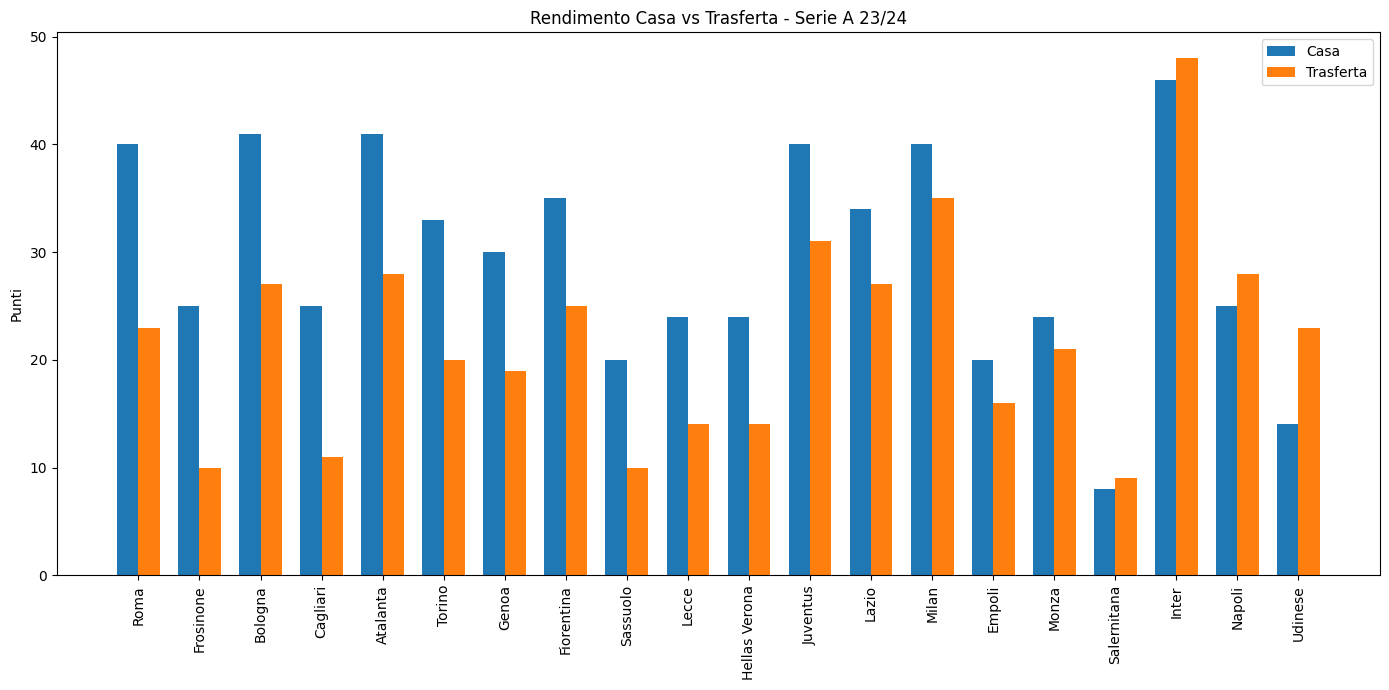

,name,points_home,points_away,points_diff
4,Roma,40,23,17
12,Frosinone,25,10,15
2,Bologna,41,27,14
11,Cagliari,25,11,14
1,Atalanta,41,28,13
8,Torino,33,20,13
9,Genoa,30,19,11
6,Fiorentina,35,25,10
17,Sassuolo,20,10,10
15,Lecce,24,14,10


In [57]:
# Unione dei dati per confronto
home = pd.read_csv('dataset/Serie A_table_home_2023_24.csv')
away = pd.read_csv('dataset/Serie A_table_away_2023_24.csv')

home_vs_away = pd.merge(
    home[['idx' ,'name','played','wins','draws','losses','scoresStr','goalConDiff','pts']],
    away[['idx' ,'name','played','wins','draws','losses','scoresStr','goalConDiff','pts']],
    on='name',
    suffixes=('_home', '_away')
)

# Calcolo punti casa/trasferta (3 punti vittoria, 1 punto pareggio)
home_vs_away['points_home'] = home_vs_away['wins_home'] * 3 + home_vs_away['draws_home']
home_vs_away['points_away'] = home_vs_away['wins_away'] * 3 + home_vs_away['draws_away']

# Calcolo differenza punti
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento per chi ha più differenza casa/trasferta
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# Numero squadre
N = len(home_vs_away_sorted)
ind = np.arange(N)  # posizione X
width = 0.35  # larghezza barre

plt.figure(figsize=(14, 7))
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Casa')
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Trasferta')

plt.ylabel('Punti')
plt.title('Rendimento Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Mostra tabella riassuntiva
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]


## Analisi offensiva e difensiva delle squadre

Esaminiamo il rendimento offensivo e difensivo delle squadre. Questo ci può aiutare a capire quali squadre segnano di più e quali subiscono meno gol, fattori determinanti per predire i risultati.

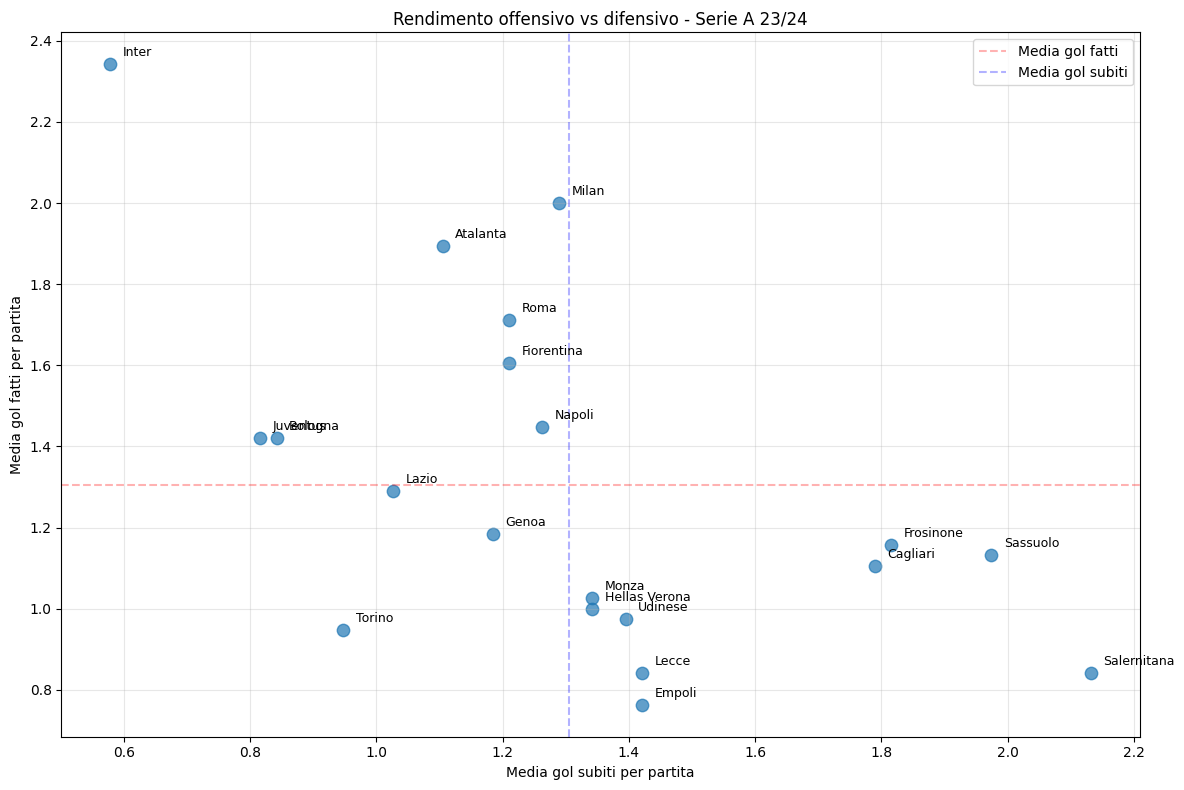

In [58]:
home_vs_away[['GolFatti_casa', 'GolSubiti_casa']] = home_vs_away['scoresStr_home'].str.split('[:|-]', expand=True).astype(int)
home_vs_away[['GolFatti_trasferta', 'GolSubiti_trasferta']] = home_vs_away['scoresStr_away'].str.split('[:|-]', expand=True).astype(int)

home_vs_away['Media_gol_fatti'] = (home_vs_away['GolFatti_casa'] + home_vs_away['GolFatti_trasferta']) / (home_vs_away['played_home'] + home_vs_away['played_away'])
home_vs_away['Media_gol_subiti'] = (home_vs_away['GolSubiti_casa'] + home_vs_away['GolSubiti_trasferta']) / (home_vs_away['played_home'] + home_vs_away['played_away'])

# Plottiamo un grafico a dispersione
plt.figure(figsize=(12, 8))
plt.scatter(home_vs_away['Media_gol_subiti'], home_vs_away['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiungiamo i nomi delle squadre
for idx, row in home_vs_away.iterrows():
    plt.annotate(row['name'], # Use the 'name' column for team names
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02),
                 fontsize=9)

plt.axhline(y=home_vs_away['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.3, label='Media gol fatti')
plt.axvline(x=home_vs_away['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.3, label='Media gol subiti')

plt.xlabel('Media gol subiti per partita')
plt.ylabel('Media gol fatti per partita')
plt.title('Rendimento offensivo vs difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Distribuzione dei risultati nel campionato

Analizziamo la distribuzione dei vari tipi di risultato (vittoria casa, pareggio, vittoria trasferta) per comprendere meglio le probabilità di base di ciascun esito.

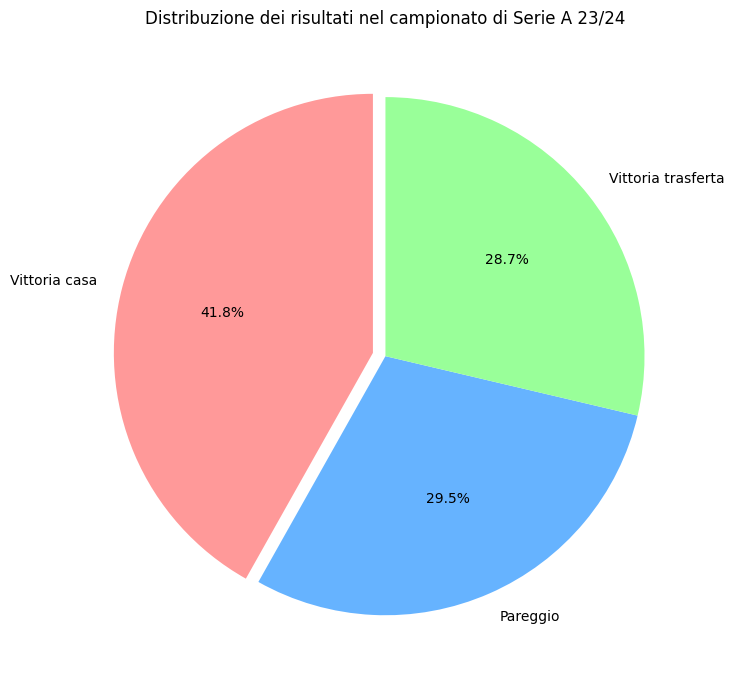

Vittorie in casa: 159 (41.8%)
Pareggi: 112 (29.5%)
Vittorie in trasferta: 109 (28.7%)


In [59]:
# Analizziamo la distribuzione dei risultati (1, X, 2)
risultati_count = matches['Risultato'].value_counts()

# Creiamo un grafico a torta
plt.figure(figsize=(10, 7))
plt.pie(risultati_count, labels=['Vittoria casa', 'Pareggio', 'Vittoria trasferta'] if len(risultati_count) == 3 else risultati_count.index, 
        autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0] if len(risultati_count) == 3 else None,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribuzione dei risultati nel campionato di Serie A 23/24')
plt.tight_layout()
plt.show()

print(f"Vittorie in casa: {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/len(matches)*100:.1f}%)")
print(f"Pareggi: {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/len(matches)*100:.1f}%)")
print(f"Vittorie in trasferta: {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/len(matches)*100:.1f}%)")

### Classifica reale vs Expected Goals (xG)

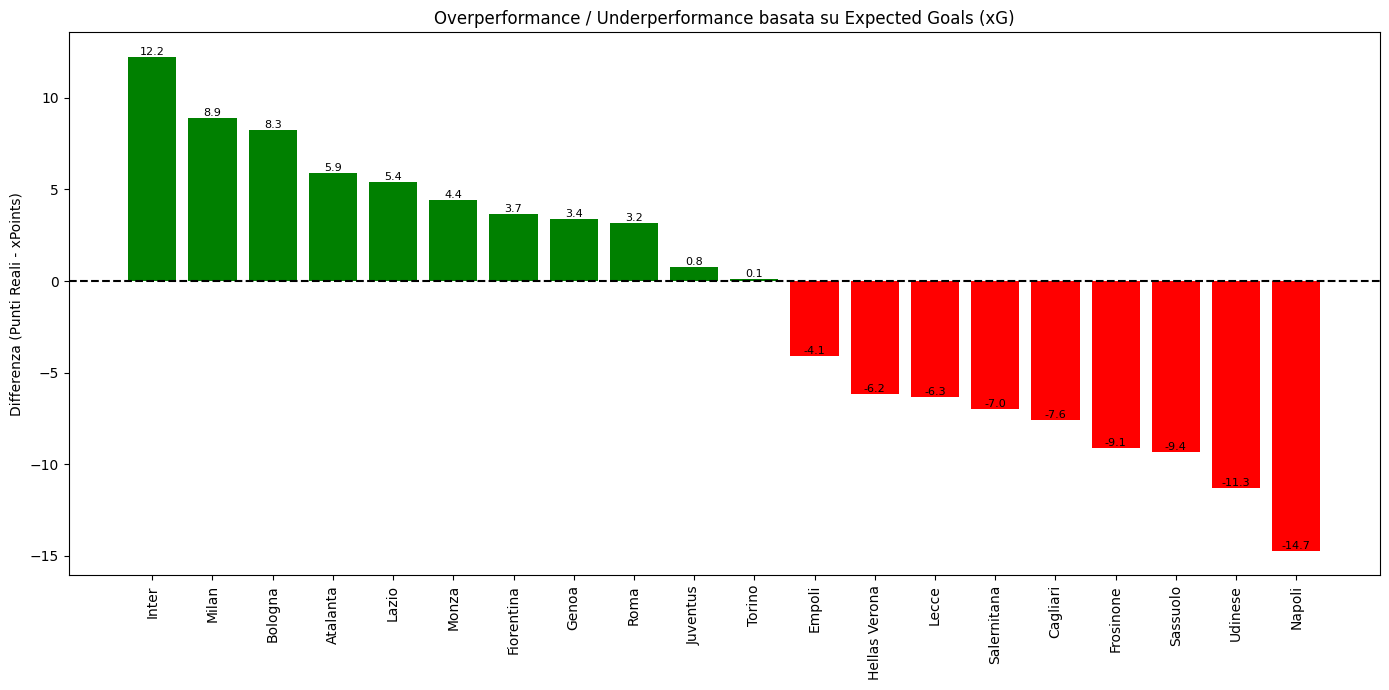

             name  pts    xPoints       diff
0           Inter   94  81.770904  12.229096
1           Milan   75  66.109611   8.890389
4         Bologna   68  59.749251   8.250749
3        Atalanta   69  63.097566   5.902434
6           Lazio   61  55.577535   5.422465
11          Monza   45  40.556915   4.443085
7      Fiorentina   60  56.317305   3.682695
10          Genoa   49  45.626036   3.373964
5            Roma   63  59.841562   3.158438
2        Juventus   71  70.235403   0.764597
8          Torino   53  52.872503   0.127497
16         Empoli   36  40.066971  -4.066971
12  Hellas Verona   38  44.156123  -6.156123
13          Lecce   38  44.322273  -6.322273
19    Salernitana   17  23.963821  -6.963821
15       Cagliari   36  43.601563  -7.601563
17      Frosinone   35  44.089054  -9.089054
18       Sassuolo   30  39.352546  -9.352546
14        Udinese   37  48.323760 -11.323760
9          Napoli   53  67.713537 -14.713537


In [60]:
sa = pd.read_csv('dataset/Serie A_table_2023_24.csv')
xg = pd.read_csv('dataset/Serie A_table_xg_2023_24.csv')
merged = pd.merge(sa[['name', 'pts']], xg[['name', 'xPoints']], on='name')
# Calcolo differenza punti reali - punti attesi
merged['diff'] = merged['pts'] - merged['xPoints']

# Ordinamento per chi over/underperforma di più
merged_sorted = merged.sort_values('diff', ascending=False)
plt.figure(figsize=(14, 7))
bars = plt.bar(merged_sorted['name'], merged_sorted['diff'], color=['green' if x > 0 else 'red' for x in merged_sorted['diff']])

plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('Differenza (Punti Reali - xPoints)')
plt.title('Overperformance / Underperformance basata su Expected Goals (xG)')

# Aggiungiamo le etichette sulle barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval,1), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Mostriamo anche la tabella per riferimento
print(merged_sorted[['name', 'pts', 'xPoints', 'diff']])

Da come possiamo notare dal grafico:

Inter, Milan, Bologna → Squadre molto efficienti, probabilmente hanno avuto anche un po’ di fortuna/cinismo.
Napoli, Udinese, Sassuolo → Squadre sfortunate o poco concrete davanti alla porta.

In particolare, il Napoli ha ben 14 punti in meno rispetto a quanto ci si aspetterebbe dagli xG! Questo suggerisce che sta creando buone occasioni, ma non riesce a concretizzarle.

DA FARE IPOTESI

PREDIZIONE DELLE ULTIME 5 GIORNATE

train per le partite che vanno dalle 1 alla 32 e test per quelle dalla 33 alla 38
Così potremo lavorare solo sui matche che ci interessano per addestrare il modello e predire le ultime 5 giornate.

In [61]:
# Iniziamo isolando i dati di addestramento (giornate 1-32) e di test (giornate 33-38)
train_df = matches[matches["Round"] <= 32].copy()
test_df = matches[matches["Round"] >= 33].copy()

Costruiamo ora i dati in tempo reale.
Per ogni squadra e per ogni giornata andremo ad aggiornare le statistiche in tempo reale.
avremo così una tabella che si aggiorna ad ogni giornata con le colonne interessate aggiornate: 
- Home_GoalFatti  
- Home_GoalSubiti
- Home_Pts	 
- Away_GoalFatti  
- Away_GoalSubiti 
- Away_Pts

In [62]:
# Lista di tutte le squadre
teams = pd.unique(train_df[['Home Team', 'Away Team']].values.ravel())

# Iniziamo costruendo un dizionario con le statistiche iniziali per ogni squadra
team_stats = {team: {
    'partite_giocate': 0,
    'gol_fatti': 0,
    'gol_subiti': 0,
    'vittorie': 0,
    'pareggi': 0,
    'sconfitte': 0,
    'punti': 0
} for team in teams}

# Creeremo una lista per memorizzare le feature per ogni riga
match_features = []

# Ordiniamo per giornata per mantenere la cronologia
train_df = train_df.sort_values(by="Round")

# Cicliamo sulle partite per generare statistiche aggiornate PRIMA di ogni match
for idx, row in train_df.iterrows():
    home = row['Home Team']
    away = row['Away Team']
    gh = row['Score_casa']
    ga = row['Score_trasferta']
    result = row['Risultato']
    
    # Recuperiamo le statistiche PRIMA della partita
    home_stats = team_stats[home].copy()
    away_stats = team_stats[away].copy()
    
    # Salviamo le feature
    match_features.append({
        'Round': row['Round'],
        'Home Team': home,
        'Away Team': away,
        'Home_GoalFatti': home_stats['gol_fatti'],
        'Home_GoalSubiti': home_stats['gol_subiti'],
        'Home_Pts': home_stats['punti'],
        'Away_GoalFatti': away_stats['gol_fatti'],
        'Away_GoalSubiti': away_stats['gol_subiti'],
        'Away_Pts': away_stats['punti'],
        'Risultato': result
    })
    
    # Dopo aver salvato, aggiorniamo le statistiche
    team_stats[home]['partite_giocate'] += 1
    team_stats[away]['partite_giocate'] += 1
    team_stats[home]['gol_fatti'] += gh
    team_stats[home]['gol_subiti'] += ga
    team_stats[away]['gol_fatti'] += ga
    team_stats[away]['gol_subiti'] += gh
    
    if result == '1':
        team_stats[home]['vittorie'] += 1
        team_stats[home]['punti'] += 3
        team_stats[away]['sconfitte'] += 1
    elif result == '2':
        team_stats[away]['vittorie'] += 1
        team_stats[away]['punti'] += 3
        team_stats[home]['sconfitte'] += 1
    elif result == 'X':
        team_stats[home]['pareggi'] += 1
        team_stats[away]['pareggi'] += 1
        team_stats[home]['punti'] += 1
        team_stats[away]['punti'] += 1

# Convertiamo la lista di dizionari in un DataFrame
train_features_df = pd.DataFrame(match_features)
train_features_df.head(10)


,Round,Home Team,Away Team,Home_GoalFatti,Home_GoalSubiti,Home_Pts,Away_GoalFatti,Away_GoalSubiti,Away_Pts,Risultato
0,1,Genoa,Fiorentina,0,0,0,0,0,0,2
1,1,Inter,Monza,0,0,0,0,0,0,1
2,1,Roma,Salernitana,0,0,0,0,0,0,X
3,1,Sassuolo,Atalanta,0,0,0,0,0,0,2
4,1,Lecce,Lazio,0,0,0,0,0,0,1
5,1,Udinese,Juventus,0,0,0,0,0,0,2
6,1,Torino,Cagliari,0,0,0,0,0,0,X
7,1,Bologna,Milan,0,0,0,0,0,0,2
8,1,Frosinone,Napoli,0,0,0,0,0,0,2
9,1,Empoli,Hellas Verona,0,0,0,0,0,0,2


In [63]:
train_features_df.tail(10)

,Round,Home Team,Away Team,Home_GoalFatti,Home_GoalSubiti,Home_Pts,Away_GoalFatti,Away_GoalSubiti,Away_Pts,Risultato
310,32,Atalanta,Hellas Verona,57,37,50,28,42,27,X
311,32,Udinese,Roma,30,47,28,56,35,55,2
312,32,Lazio,Salernitana,37,34,46,25,64,15,1
313,32,Napoli,Frosinone,48,38,48,38,61,26,X
314,32,Inter,Cagliari,75,15,82,32,52,30,X
315,32,Fiorentina,Genoa,45,37,46,34,38,38,X
316,32,Bologna,Monza,45,25,58,34,41,42,X
317,32,Sassuolo,Milan,36,59,25,60,34,68,X
318,32,Lecce,Empoli,26,48,29,25,47,28,1
319,32,Torino,Juventus,31,29,44,45,24,62,X
